# County-level Analysis of COVID-19

## Kansas City Metropolitan Area

This Juptyer Notebook is © 2020 Stacey Adams and is available under the  [MIT License](https://choosealicense.com/licenses/mit/).

## Dataset

1. COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, published at [https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19) under a [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression

In [2]:
# read data
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

# clean up columns
df.drop(['UID', 'iso2', 'iso3', 'code3', 'Combined_Key'], axis=1, inplace=True)
df.rename(columns={'Admin2': 'County', 'Province_State': 'State', 'Country_Region': 'Country'}, inplace=True)

# Flag KCMO with a special FIPS code to replace the NaN (numbering follows independent city numbering in VA)
df.loc[(df.County == 'Kansas City') & (df.State == 'Missouri'), 'FIPS'] = 29515

# drop rows with NaN in FIPS column
df.dropna(subset=['FIPS'], inplace=True)

# convert FIPS to integer from float
df = df.astype({'FIPS': 'int32'})

# remove rows with FIPS >= 80000 (used to denote "out of state" or unassigned data)
df = df[df['FIPS'] < 80000]

# convert FIPS to string
df = df.astype({'FIPS': 'str'})
df.dtypes

# add StateCode, CountyCode, and Label columns before the dated columns
df.insert(6, 'StateCode', 0)
df.insert(7, 'CountyCode', 0)
df.insert(8, 'Label', '')

# split FIPS code into county and state codes
df['StateCode'] = df['FIPS'].str.slice(stop=-3)
df['CountyCode'] = df['FIPS'].str.slice(start=-3)

# set label
df.loc[(df.CountyCode.astype(int) < 510), 'Label'] = df['County'] + ' County, ' + df['State']
df.loc[(df.CountyCode.astype(int) >= 510), 'Label'] = df['County'] + ', ' + df['State']

# convert date columns from string to datetime objects
df.columns = df.columns[:9].tolist() + pd.to_datetime(df.columns[9:]).tolist()
date_columns = df.columns[9:]

# convert cumulative totals by day to daily change counts
columns = df.columns.tolist()
columns.reverse()
for index, value in enumerate(columns):
  if index >= len(columns) - 1:
    break
  previous_value = columns[index + 1]
  if (type(value) != str) & (type(previous_value) != str):
    df[value] = df[value] - df[previous_value]
  else:
    break

# clean up negative numbers in daily change counts by reducing the previous day's count
for index, value in enumerate(columns):
  if index >= len(columns) -1:
    break
  previous_value = columns[index + 1]
  if (type(value) != str) & (type(previous_value) != str):
    df.loc[(df[value] < 0), previous_value] = df[previous_value] + df[value]
    df.loc[(df[value] < 0), value] = 0
  else:
    break

df

,FIPS,County,State,Country,Lat,Long_,StateCode,CountyCode,Label,2020-01-22 00:00:00,...,2020-10-18 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-25 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00
0,1001,Autauga,Alabama,US,32.539527,-86.644082,1,001,"Autauga County, Alabama",0,...,6,10,11,11,2,7,18,11,15,8
1,1003,Baldwin,Alabama,US,30.727750,-87.722071,1,003,"Baldwin County, Alabama",0,...,19,6,30,38,32,140,22,21,36,18
2,1005,Barbour,Alabama,US,31.868263,-85.387129,1,005,"Barbour County, Alabama",0,...,4,0,7,8,1,15,19,2,0,9
3,1007,Bibb,Alabama,US,32.996421,-87.125115,1,007,"Bibb County, Alabama",0,...,10,4,2,10,10,14,3,12,3,7
4,1009,Blount,Alabama,US,33.982109,-86.567906,1,009,"Blount County, Alabama",0,...,20,11,10,25,20,18,14,7,10,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,56037,Sweetwater,Wyoming,US,41.659439,-108.882788,56,037,"Sweetwater County, Wyoming",0,...,4,7,6,8,7,8,5,6,14,12
3335,56039,Teton,Wyoming,US,43.935225,-110.589080,56,039,"Teton County, Wyoming",0,...,8,11,4,0,12,13,3,4,9,5
3336,56041,Uinta,Wyoming,US,41.287818,-110.547578,56,041,"Uinta County, Wyoming",0,...,0,2,1,3,3,15,3,3,11,9
3338,56043,Washakie,Wyoming,US,43.904516,-107.680187,56,043,"Washakie County, Wyoming",0,...,1,1,4,3,1,1,1,0,1,5


In [3]:
# define data for Kansas and Missouri
df_mokan = df[(df['State'] == 'Missouri') | (df['State'] == 'Kansas')]
df_mokan

,FIPS,County,State,Country,Lat,Long_,StateCode,CountyCode,Label,2020-01-22 00:00:00,...,2020-10-18 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-25 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00
924,20001,Allen,Kansas,US,37.885830,-95.300308,20,001,"Allen County, Kansas",0,...,0,0,8,0,0,0,0,0,0,0
925,20003,Anderson,Kansas,US,38.214133,-95.292728,20,003,"Anderson County, Kansas",0,...,0,23,30,0,0,0,0,0,10,0
926,20005,Atchison,Kansas,US,39.531857,-95.308700,20,005,"Atchison County, Kansas",0,...,0,40,0,0,0,12,0,0,0,0
927,20007,Barber,Kansas,US,37.228859,-98.684601,20,007,"Barber County, Kansas",0,...,0,1,0,4,0,5,0,0,5,0
928,20009,Barton,Kansas,US,38.478897,-98.756367,20,009,"Barton County, Kansas",0,...,0,25,0,15,0,13,0,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,29221,Washington,Missouri,US,37.961301,-90.879482,29,221,"Washington County, Missouri",0,...,15,5,2,2,12,6,15,21,3,5
1654,29223,Wayne,Missouri,US,37.113039,-90.460014,29,223,"Wayne County, Missouri",0,...,1,1,2,1,1,2,2,8,0,0
1655,29225,Webster,Missouri,US,37.281373,-92.876329,29,225,"Webster County, Missouri",0,...,18,8,6,9,18,11,17,27,7,4
1656,29227,Worth,Missouri,US,40.479456,-94.423288,29,227,"Worth County, Missouri",0,...,0,0,0,1,2,0,2,0,3,0


In [4]:
# define the data for the KC Metro Area, as defined by MARC (Mid-America Regional Council)

df_marc = df[
    (df['FIPS'] == '29165') |
    (df['FIPS'] == '29047') |
    (df['FIPS'] == '29177') |
    (df['FIPS'] == '29095') |
    (df['FIPS'] == '29515') |
    (df['FIPS'] == '29037') |
    (df['FIPS'] == '20103') |
    (df['FIPS'] == '20209') |
    (df['FIPS'] == '20091') |
    (df['FIPS'] == '20121')
]
df_marc

,FIPS,County,State,Country,Lat,Long_,StateCode,CountyCode,Label,2020-01-22 00:00:00,...,2020-10-18 00:00:00,2020-10-19 00:00:00,2020-10-20 00:00:00,2020-10-21 00:00:00,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-25 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00
969,20091,Johnson,Kansas,US,38.885482,-94.822509,20,091,"Johnson County, Kansas",0,...,77,62,83,143,80,117,152,105,62,224
975,20103,Leavenworth,Kansas,US,39.201835,-95.036208,20,103,"Leavenworth County, Kansas",0,...,0,47,0,22,0,27,0,0,20,0
984,20121,Miami,Kansas,US,38.563834,-94.838322,20,121,"Miami County, Kansas",0,...,0,3,0,32,0,0,0,0,0,0
1030,20209,Wyandotte,Kansas,US,39.117273,-94.763782,20,209,"Wyandotte County, Kansas",0,...,18,19,40,66,37,29,23,29,89,8
1558,29037,Cass,Missouri,US,38.647894,-94.353399,29,037,"Cass County, Missouri",0,...,17,11,26,20,11,27,26,15,12,38
1563,29047,Clay,Missouri,US,39.311321,-94.418509,29,047,"Clay County, Missouri",0,...,17,0,23,24,65,37,28,14,13,32
1587,29095,Jackson,Missouri,US,39.010022,-94.347245,29,095,"Jackson County, Missouri",0,...,86,22,114,74,157,121,103,90,89,89
1591,29515,Kansas City,Missouri,US,39.099700,-94.578600,29,515,"Kansas City, Missouri",0,...,115,119,59,77,35,85,128,112,84,122
1624,29165,Platte,Missouri,US,39.381544,-94.770685,29,165,"Platte County, Missouri",0,...,15,6,12,5,19,11,9,11,1,14
1630,29177,Ray,Missouri,US,39.353747,-93.989057,29,177,"Ray County, Missouri",0,...,0,3,11,5,5,3,4,6,3,1


In [5]:
sns.set_context("talk")
sns.set_style("whitegrid")

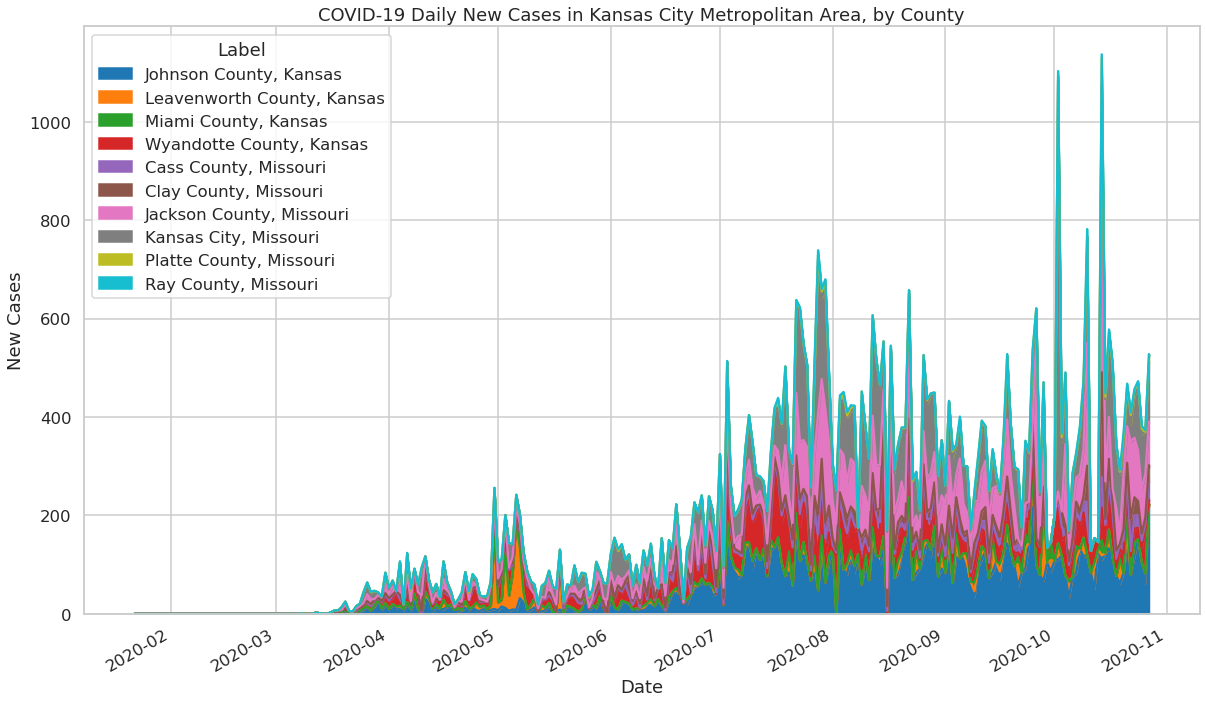

In [6]:
df_graph = df_marc.copy()
df_graph.set_index('Label', inplace=True)
df_graph.drop(columns={'FIPS','County','State','Country','Lat','Long_','StateCode','CountyCode'}, inplace=True)
df_graph = df_graph.transpose()
df_graph.plot(kind='area', stacked=True, figsize=(20,12))
plt.title('COVID-19 Daily New Cases in Kansas City Metropolitan Area, by County')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.show()

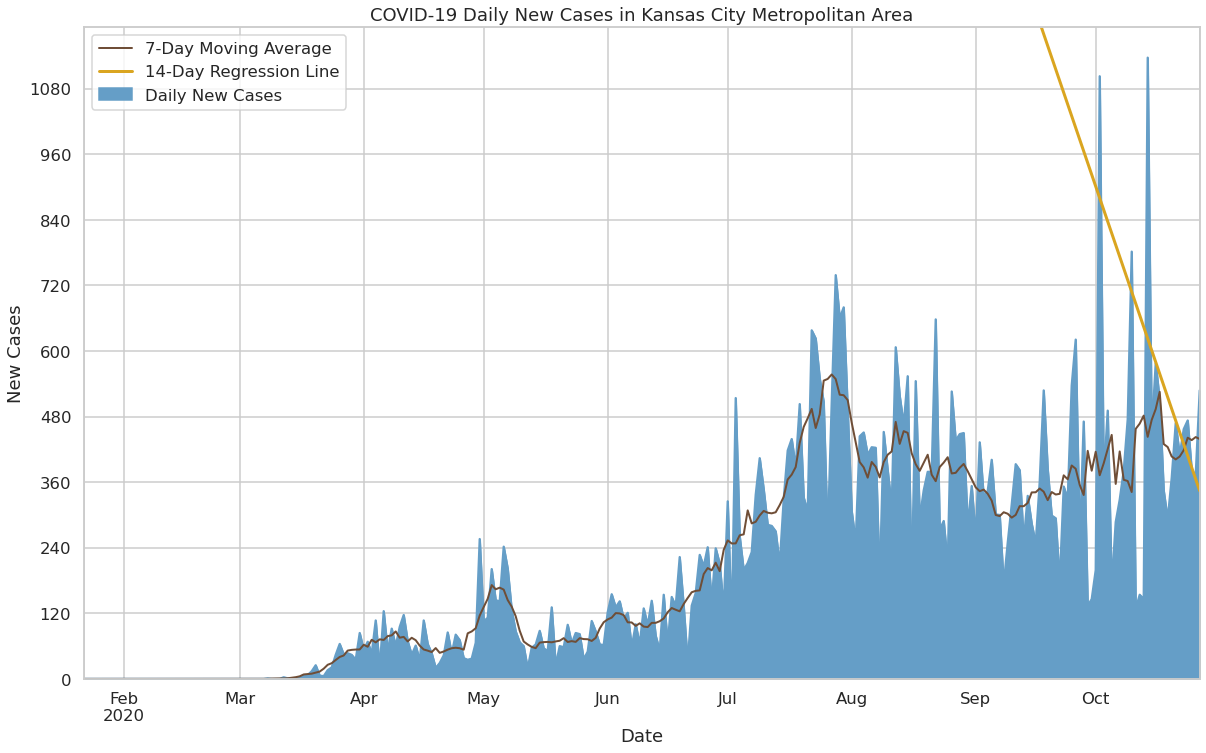

In [7]:
# Set up the dataframe for graphing
df_metro_graph = df_marc[date_columns].sum().transpose().to_frame('Daily New Cases')
df_metro_graph['7-Day Moving Average'] = df_metro_graph['Daily New Cases'].rolling(7, min_periods=3, center=True).mean()
df_metro_graph.index.rename('Date', inplace=True)
df_metro_graph.reset_index(inplace=True)

# Extract the last 14 records for regression
df_metro_regress = df_metro_graph[-14:]
regress_x = df_metro_regress['Date'].map(datetime.toordinal).values.reshape(-1, 1)
regress_y = df_metro_regress['Daily New Cases'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(regress_x, regress_y)

# Calculate the regression value for the entire time period
test_x = df_metro_graph['Date'].map(datetime.toordinal).values.reshape(-1, 1)
regress_y_pred = linear_regressor.predict(test_x)
df_regress = pd.DataFrame(data={'Date': test_x.reshape(len(test_x)), '14-Day Regression Line': regress_y_pred.reshape(len(regress_y_pred))})
df_regress['Date'] = df_regress['Date'].map(datetime.fromordinal)

# Plot the data
fig, ax = plt.subplots()
df_metro_graph.plot(kind='area', x='Date', y='Daily New Cases', color='#659EC7', ax=ax)
df_metro_graph.plot(kind='line', x='Date', y='7-Day Moving Average', color='#6F4E37', lw=2, ax=ax)
df_regress.plot(kind='line', x='Date', y='14-Day Regression Line', color='#daa520', lw=3, ax=ax)
fig.set_size_inches(20, 12)
ax.set_title('COVID-19 Daily New Cases in Kansas City Metropolitan Area')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases')
ax.legend()
ax.tick_params(axis='both')
locs = ax.get_yticks()
ax.set_yticks(np.arange(0, locs[locs.size-1], locs[locs.size-1] / 10))
plt.show()

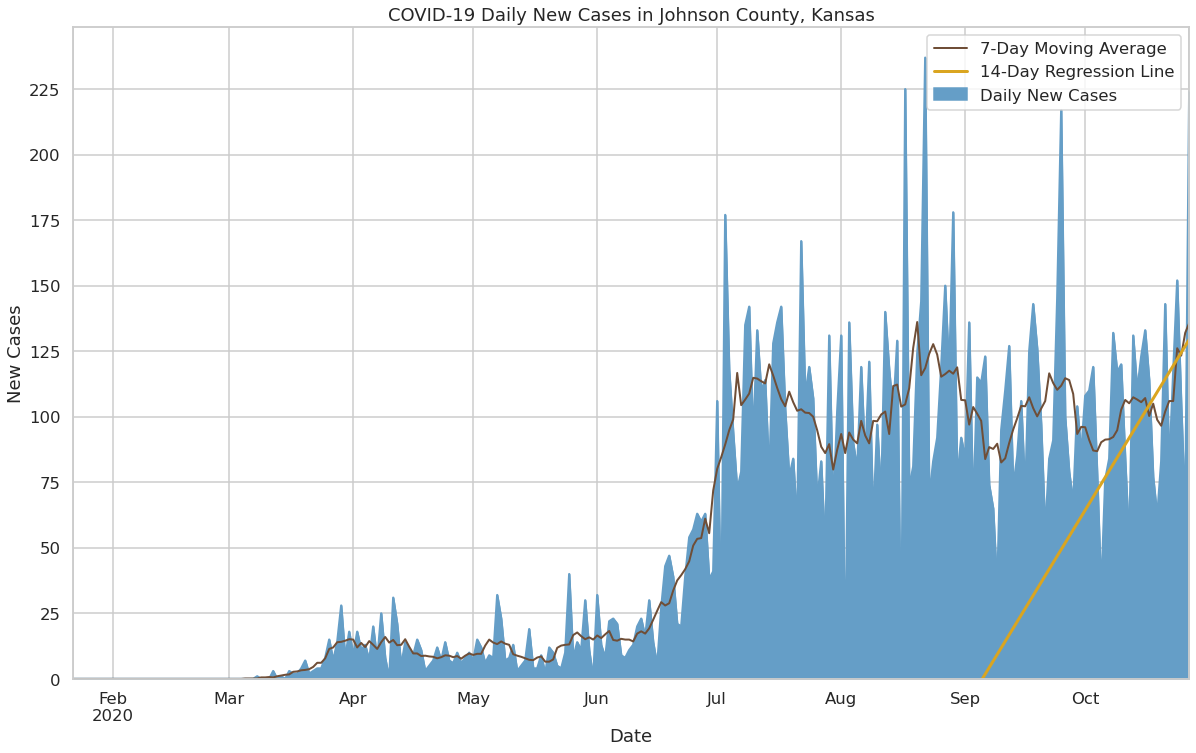

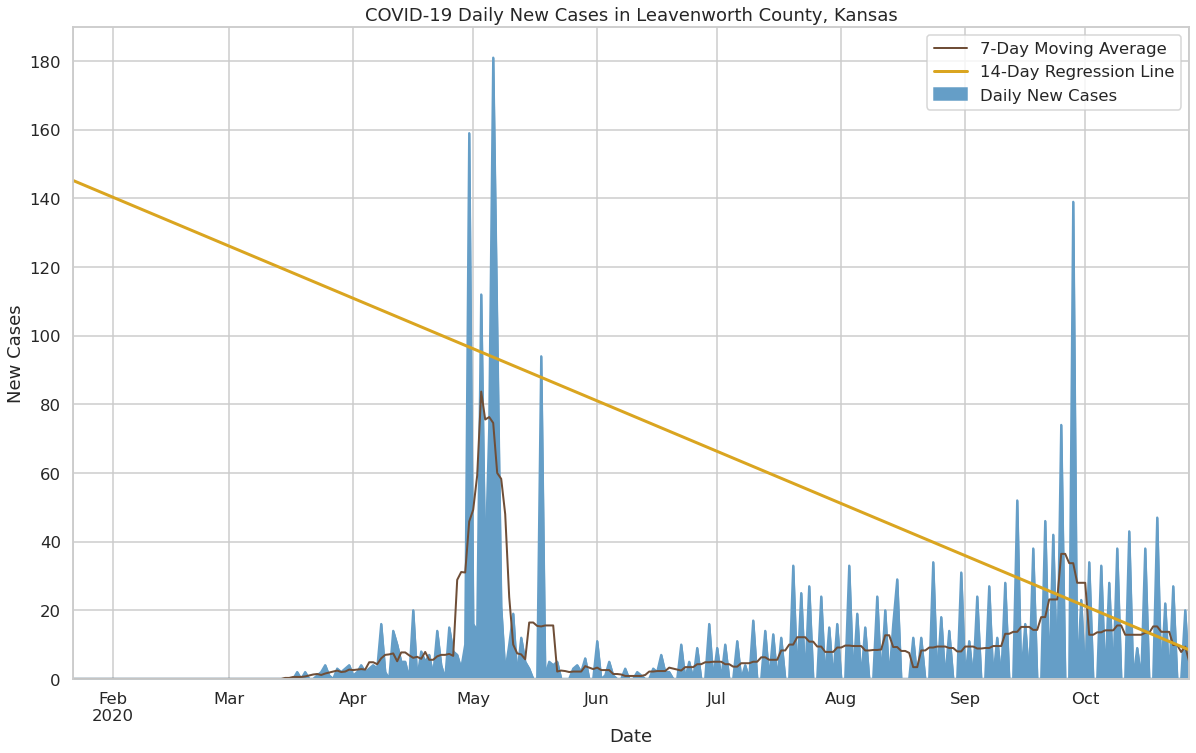

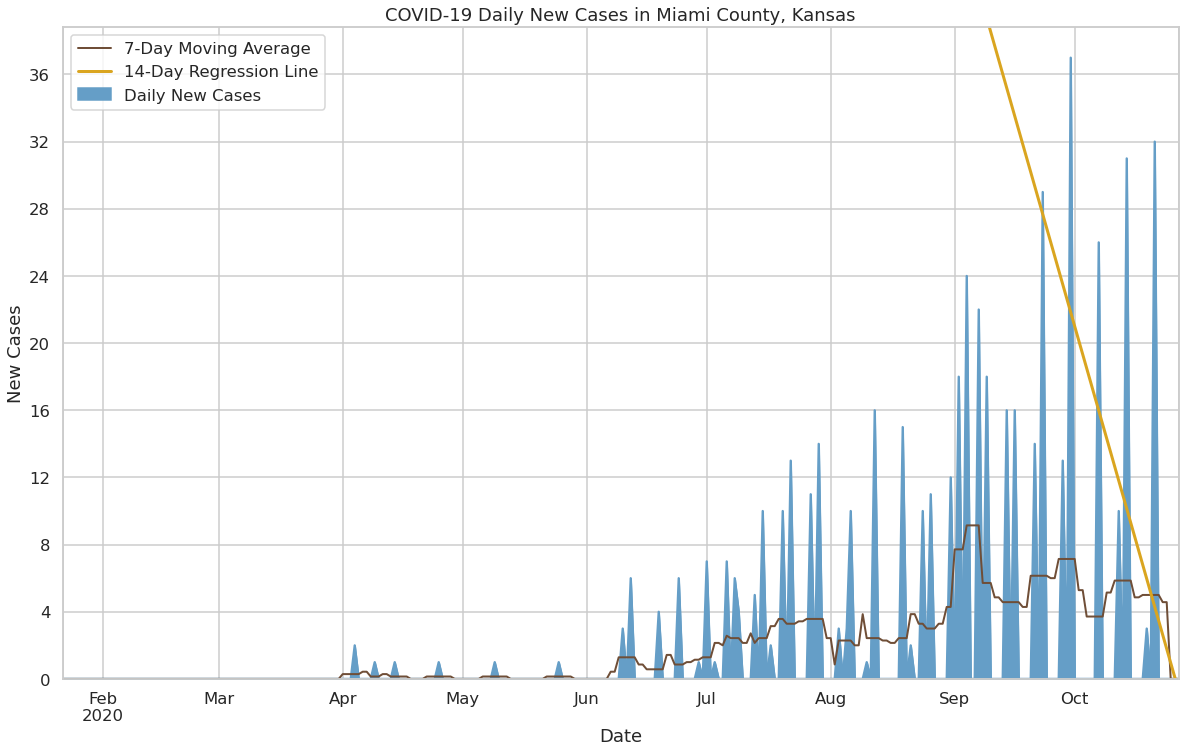

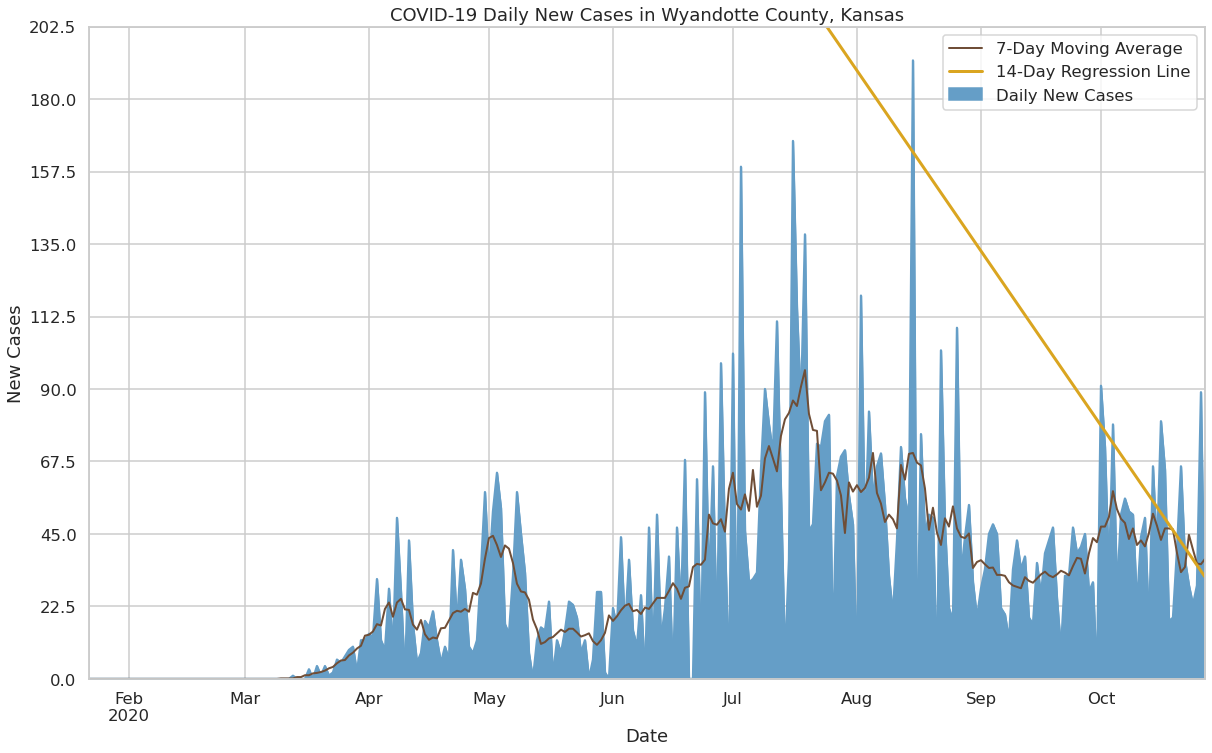

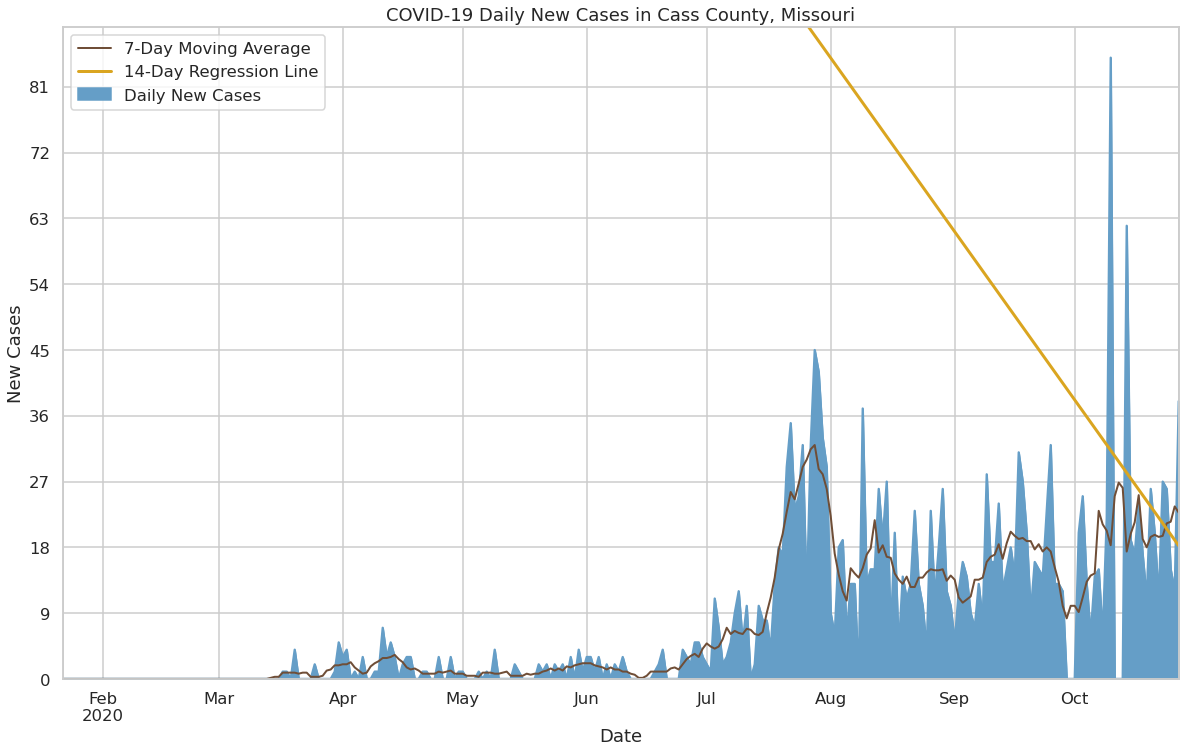

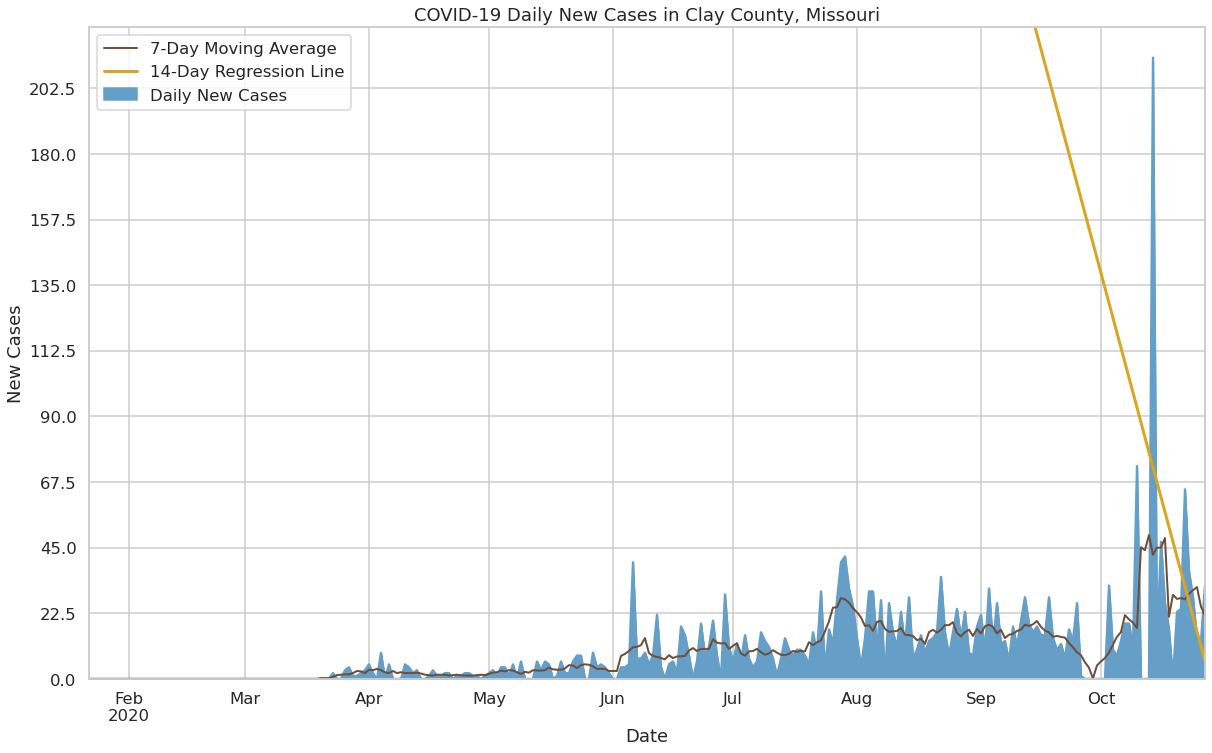

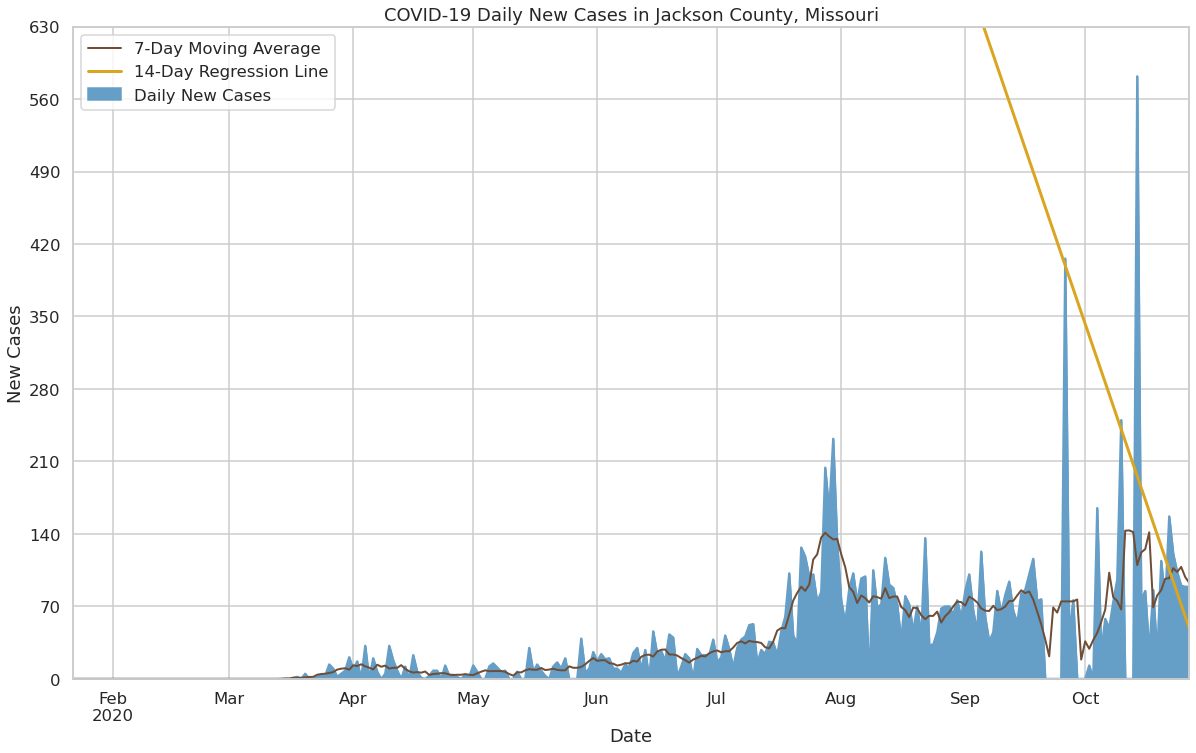

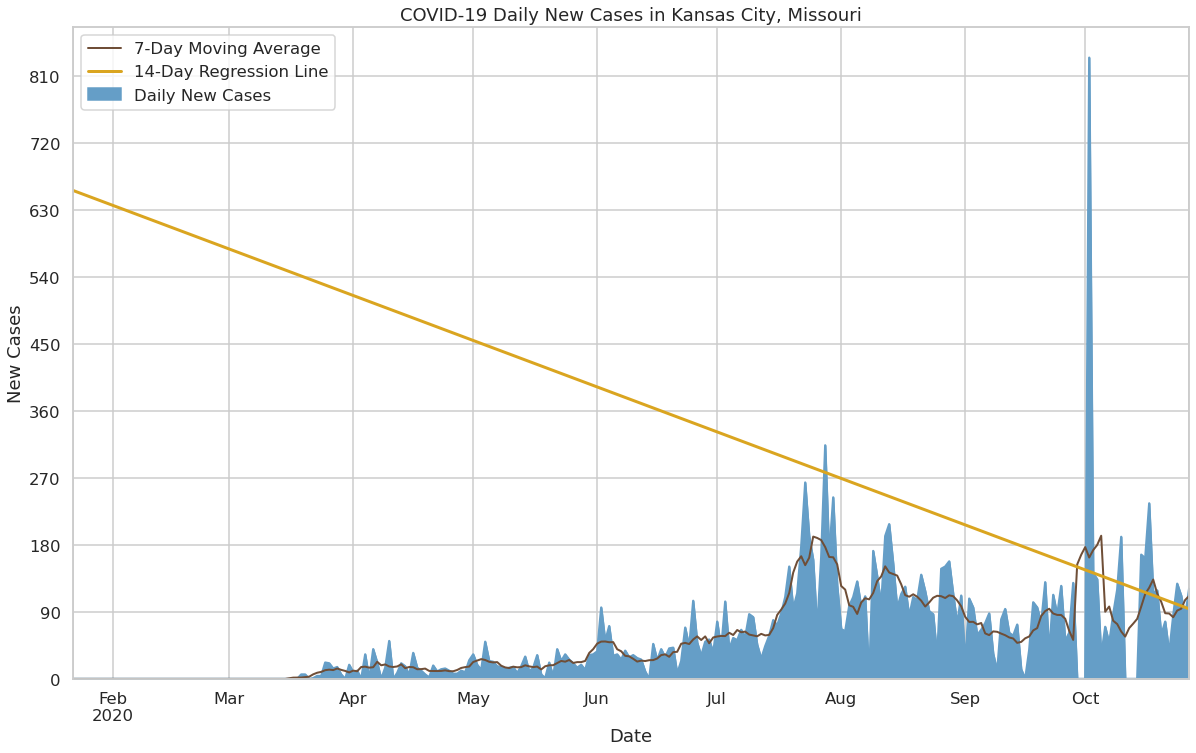

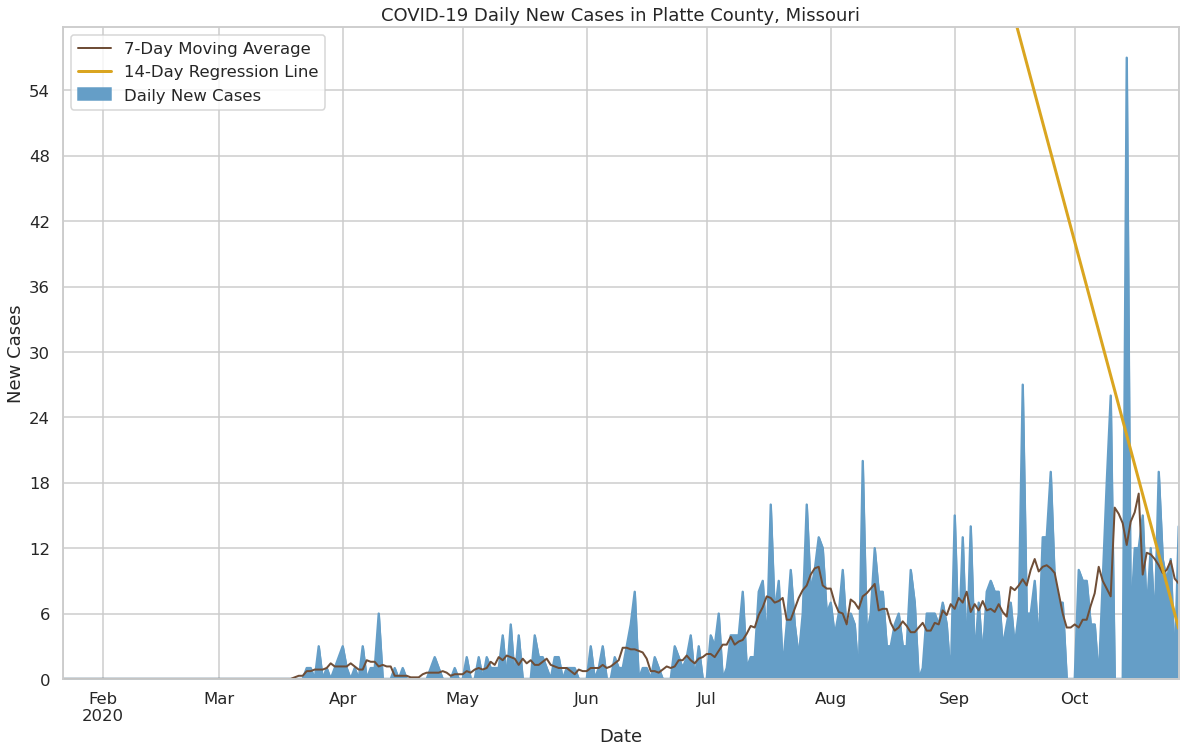

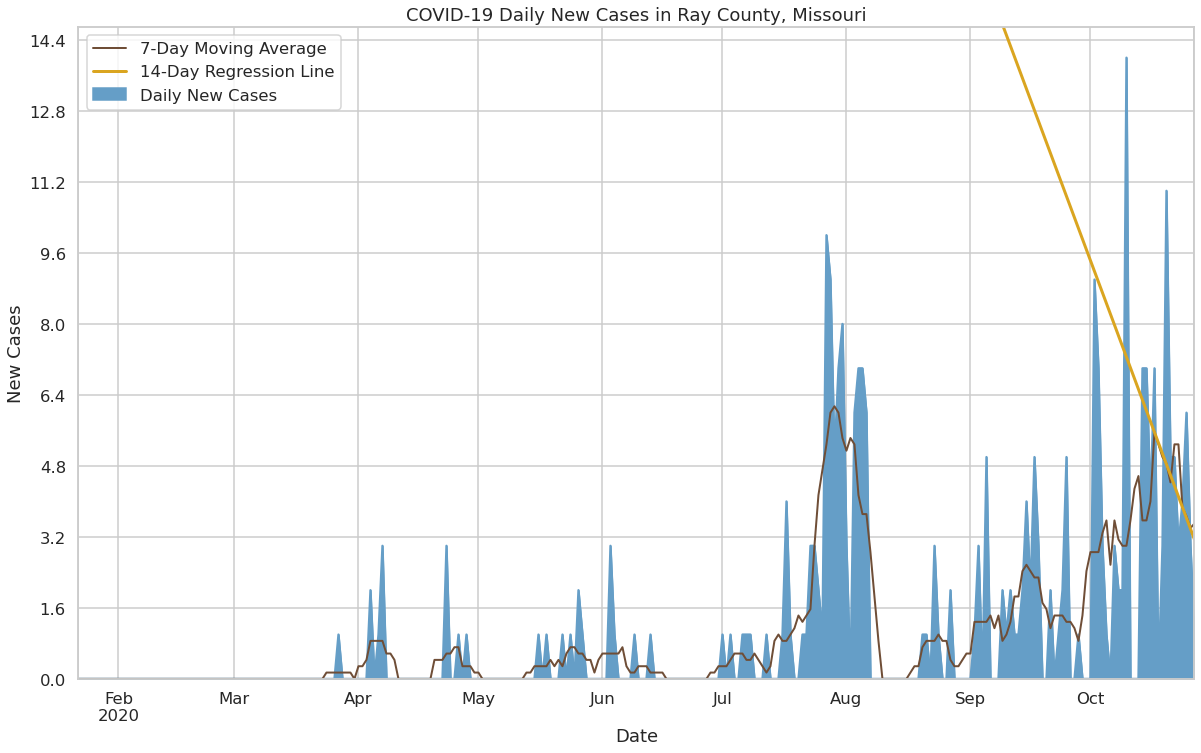

In [8]:
for fips in df_marc['FIPS']:
    query = df_marc['FIPS'] == fips
    location = df_marc.loc[query, 'Label'].iat[0]

    # Set up the dataframe for graphing
    df_metro_graph = df_marc.loc[query, date_columns].sum().transpose().to_frame('Daily New Cases')
    df_metro_graph['7-Day Moving Average'] = df_metro_graph['Daily New Cases'].rolling(7, min_periods=3, center=True).mean()
    df_metro_graph.index.rename('Date', inplace=True)
    df_metro_graph.reset_index(inplace=True)

    # Extract the last 14 records for regression
    df_metro_regress = df_metro_graph[-14:]
    regress_x = df_metro_regress['Date'].map(datetime.toordinal).values.reshape(-1, 1)
    regress_y = df_metro_regress['Daily New Cases'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(regress_x, regress_y)

    # Calculate the regression value for the entire time period
    test_x = df_metro_graph['Date'].map(datetime.toordinal).values.reshape(-1, 1)
    regress_y_pred = linear_regressor.predict(test_x)
    df_regress = pd.DataFrame(data={'Date': test_x.reshape(len(test_x)), '14-Day Regression Line': regress_y_pred.reshape(len(regress_y_pred))})
    df_regress['Date'] = df_regress['Date'].map(datetime.fromordinal)

    # Plot the data
    fig, ax = plt.subplots()
    df_metro_graph.plot(kind='area', x='Date', y='Daily New Cases', color='#659EC7', ax=ax)
    df_metro_graph.plot(kind='line', x='Date', y='7-Day Moving Average', color='#6F4E37', lw=2, ax=ax)
    df_regress.plot(kind='line', x='Date', y='14-Day Regression Line', color='#daa520', lw=3, ax=ax)
    fig.set_size_inches(20, 12)
    ax.set_title('COVID-19 Daily New Cases in %s' % location)
    ax.set_xlabel('Date')
    ax.set_ylabel('New Cases')
    ax.legend()
    ax.tick_params(axis='both')
    locs = ax.get_yticks()
    ax.set_yticks(np.arange(0, locs[locs.size-1], locs[locs.size-1] / 10))
    plt.show()